# Cars

In [6]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

## Support code

In [7]:
def carshow(m, b, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    
    plt.show()

def mshow(model, X=df_cars.WGT, y=df_cars.MPG, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    with torch.no_grad():
        y_pred = model(X)
    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, y_pred, lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    plt.show()

## Load simple data set

In [8]:
df_cars = pd.read_csv("../data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [9]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).float().reshape(n,1)
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

## Pytorch built-in linear model

Epoch   0 MSE loss      587.886 MAE    22.81
Epoch  10 MSE loss      190.337 MAE    13.02
Epoch  20 MSE loss       41.417 MAE     5.18
Epoch  30 MSE loss       20.384 MAE     3.51
Epoch  40 MSE loss       24.447 MAE     4.05
Epoch  50 MSE loss       21.187 MAE     3.67
Epoch  60 MSE loss       18.783 MAE     3.29
Epoch  70 MSE loss       18.887 MAE     3.28
LAST      MSE loss       18.887 MAE     3.28


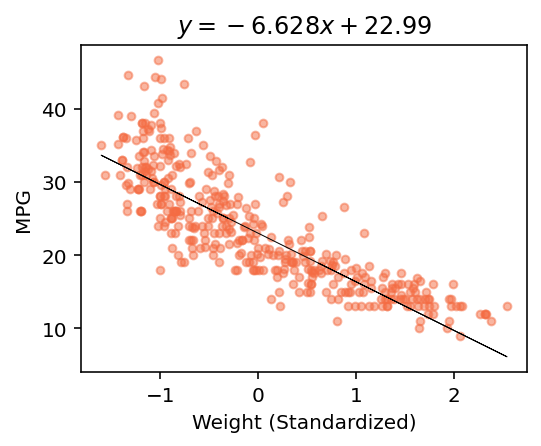

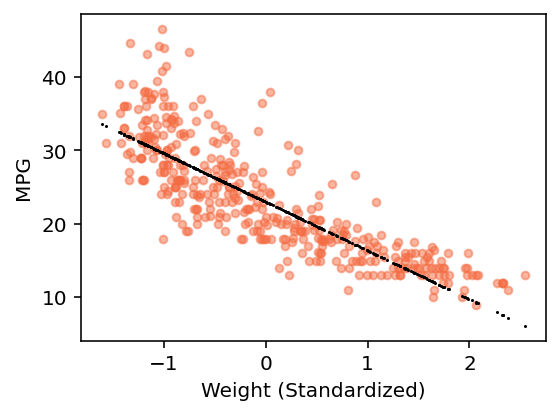

In [23]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # adjust weights
    
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

carshow(m, b, X=X, y=df_cars.MPG)
mshow(model, X=X, y=df_cars.MPG)

## Factor out a training method

In [12]:
def train(model, learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        if epoch % (nepochs//10) == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(y_pred - y))
                print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")
    return loss

Epoch    0 MSE loss      630.350 MAE    23.88
Epoch    7 MSE loss      305.803 MAE    16.94
Epoch   14 MSE loss      132.625 MAE    10.45
Epoch   21 MSE loss       42.225 MAE     5.24
Epoch   28 MSE loss       20.328 MAE     3.28
Epoch   35 MSE loss       21.389 MAE     3.70
Epoch   42 MSE loss       24.289 MAE     4.01
Epoch   49 MSE loss       22.244 MAE     3.80
Epoch   56 MSE loss       19.727 MAE     3.47
Epoch   63 MSE loss       18.701 MAE     3.29
Epoch   70 MSE loss       18.800 MAE     3.28
LAST       MSE loss       18.800 MAE     3.28


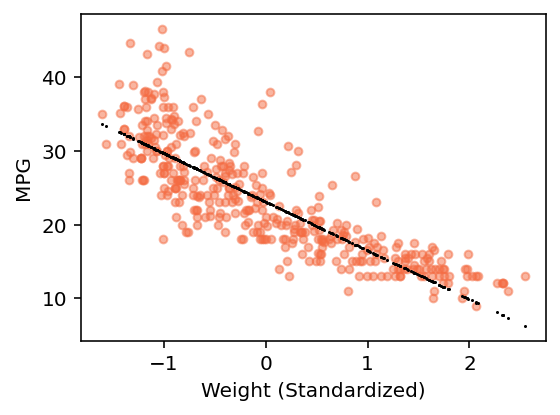

In [22]:
model = nn.Linear(1, 1)

train(model, learning_rate=1, nepochs=70)

mshow(model, X=X, y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

Unless we add relu or sigmoid, 2 models chained is same as one: it's a line.

Let's create a generic training function for given model and a new show function.

### Without nonlinearity

Epoch    0 MSE loss      657.173 MAE    24.63
Epoch   10 MSE loss       60.533 MAE     6.32
Epoch   20 MSE loss       28.971 MAE     4.63
Epoch   30 MSE loss       21.061 MAE     3.41
Epoch   40 MSE loss       20.825 MAE     3.63
Epoch   50 MSE loss       18.872 MAE     3.31
Epoch   60 MSE loss       18.742 MAE     3.27
Epoch   70 MSE loss       18.775 MAE     3.30
Epoch   80 MSE loss       18.689 MAE     3.28
Epoch   90 MSE loss       18.678 MAE     3.28
Epoch  100 MSE loss       18.680 MAE     3.28
LAST       MSE loss       18.680 MAE     3.28


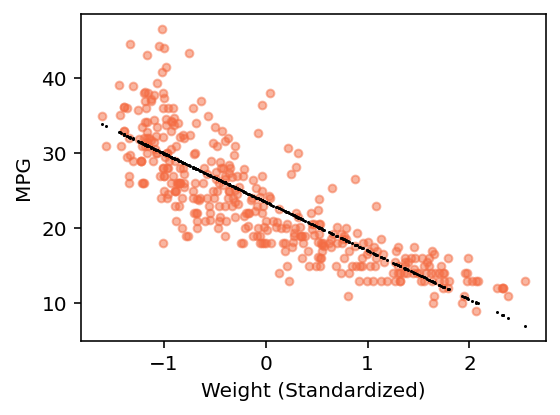

In [13]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="2linear")

### With ReLU nonlinearity

Epoch    0 MSE loss      600.115 MAE    23.24
Epoch   10 MSE loss       53.134 MAE     6.16
Epoch   20 MSE loss       45.709 MAE     5.97
Epoch   30 MSE loss       22.683 MAE     3.39
Epoch   40 MSE loss       18.353 MAE     3.16
Epoch   50 MSE loss       18.863 MAE     3.31
Epoch   60 MSE loss       17.826 MAE     3.11
Epoch   70 MSE loss       17.890 MAE     3.11
Epoch   80 MSE loss       17.760 MAE     3.14
Epoch   90 MSE loss       17.774 MAE     3.14
Epoch  100 MSE loss       17.753 MAE     3.13
LAST       MSE loss       17.753 MAE     3.13


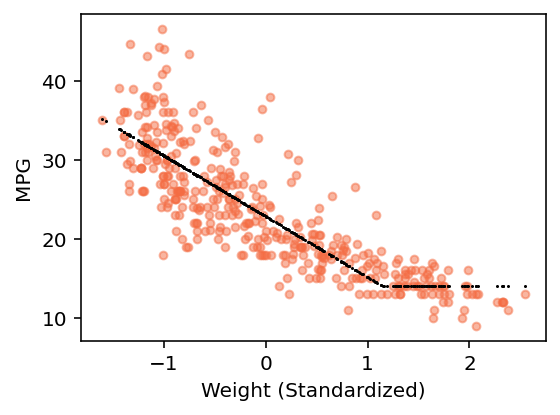

In [28]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.ReLU(),     # add nonlinearity, gives two lines
    nn.Linear(1, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="linRlin")

Epoch    0 MSE loss      633.578 MAE    24.02
Epoch   10 MSE loss       45.528 MAE     5.48
Epoch   20 MSE loss       44.799 MAE     5.72
Epoch   30 MSE loss       23.907 MAE     3.70
Epoch   40 MSE loss       20.015 MAE     3.29
Epoch   50 MSE loss       19.650 MAE     3.50
Epoch   60 MSE loss       18.549 MAE     3.28
Epoch   70 MSE loss       18.577 MAE     3.24
Epoch   80 MSE loss       18.492 MAE     3.25
Epoch   90 MSE loss       18.437 MAE     3.26
Epoch  100 MSE loss       18.407 MAE     3.27
LAST       MSE loss       18.407 MAE     3.27


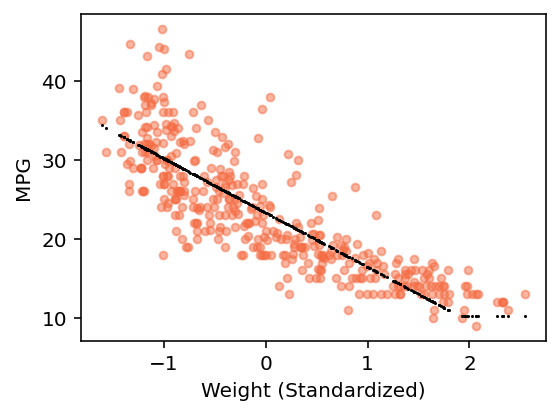

In [29]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin")

Epoch    0 MSE loss      619.704 MAE    23.65
Epoch   10 MSE loss      305.303 MAE    16.43
Epoch   20 MSE loss      105.813 MAE     8.95
Epoch   30 MSE loss       35.005 MAE     4.41
Epoch   40 MSE loss       17.653 MAE     3.10
Epoch   50 MSE loss       18.143 MAE     3.24
Epoch   60 MSE loss       18.336 MAE     3.06
Epoch   70 MSE loss       17.871 MAE     3.21
Epoch   80 MSE loss       17.592 MAE     3.04
Epoch   90 MSE loss       17.466 MAE     3.12
Epoch  100 MSE loss       17.416 MAE     3.06
LAST       MSE loss       17.416 MAE     3.06


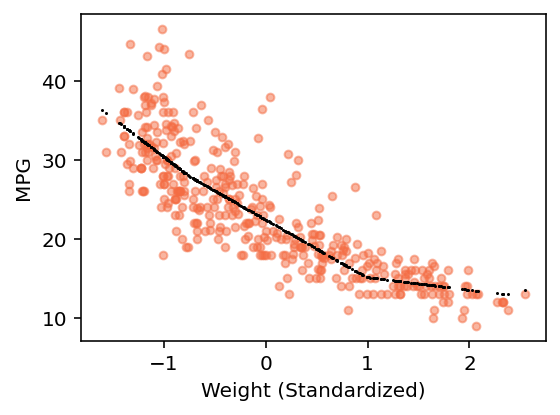

In [30]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
    nn.ReLU(),
    nn.Linear(2, 1)
)

train(model, learning_rate=.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin2")

### What matrix algebra is that model doing?

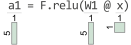

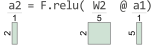

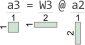

In [32]:
# Draw matrix shapes
import torch.nn.functional as F
import tsensor

W1 = torch.rand(5,1)
W2 = torch.rand(2,5)
W3 = torch.rand(1,2)
x = torch.rand(1,1)
with tsensor.explain() as e:
    a1 = F.relu(W1 @ x)
    a2 = F.relu(W2 @ a1)
    a3 = W3 @ a2

### With logistic function (sigmoid) nonlinearity

Epoch    0 MSE loss      552.503 MAE    22.17
Epoch   10 MSE loss      905.629 MAE    29.23
Epoch   20 MSE loss      244.309 MAE    13.94
Epoch   30 MSE loss       35.276 MAE     4.72
Epoch   40 MSE loss       61.853 MAE     6.11
Epoch   50 MSE loss       50.700 MAE     5.45
Epoch   60 MSE loss       40.114 MAE     4.91
Epoch   70 MSE loss       36.254 MAE     4.70
Epoch   80 MSE loss       34.674 MAE     4.64
Epoch   90 MSE loss       33.925 MAE     4.62
Epoch  100 MSE loss       33.775 MAE     4.64
LAST       MSE loss       33.775 MAE     4.64


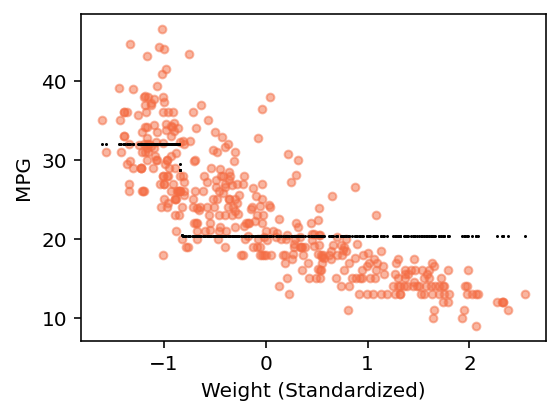

In [51]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Sigmoid(),    # doesn't converge as fast; bump learning rate
    nn.Linear(1, 1)
)

train(model, learning_rate=50, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file='linSlin')

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      613.866 MAE    23.60
Epoch  200 MSE loss       17.122 MAE     3.04
Epoch  400 MSE loss       16.911 MAE     3.03
Epoch  600 MSE loss       16.703 MAE     3.02
Epoch  800 MSE loss       16.645 MAE     3.00
Epoch 1000 MSE loss       16.657 MAE     3.03
Epoch 1200 MSE loss       16.566 MAE     2.98
Epoch 1400 MSE loss       16.615 MAE     3.02
Epoch 1600 MSE loss       16.530 MAE     2.98
Epoch 1800 MSE loss       16.542 MAE     2.97
Epoch 2000 MSE loss       16.639 MAE     2.95
LAST       MSE loss       16.639 MAE     2.95


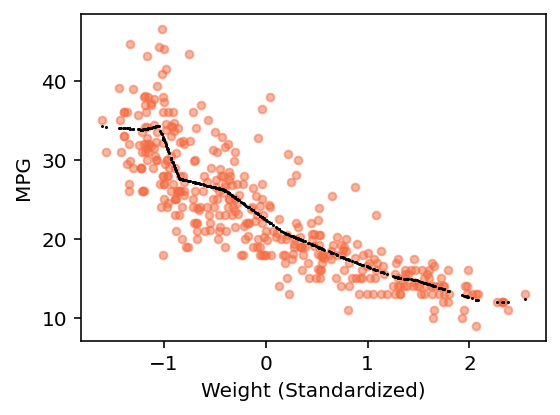

In [20]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # fast to compute, not smooth y_pred
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1)

mshow(model, X=X, y=df_cars.MPG, file="lin1kRlin")

Epoch    0 MSE loss      621.002 MAE    23.68
Epoch  150 MSE loss       17.312 MAE     3.05
Epoch  300 MSE loss       27.579 MAE     4.28
Epoch  450 MSE loss       17.260 MAE     3.05
Epoch  600 MSE loss       17.245 MAE     3.05
Epoch  750 MSE loss       17.190 MAE     3.04
Epoch  900 MSE loss       17.555 MAE     3.13
Epoch 1050 MSE loss       16.988 MAE     3.01
Epoch 1200 MSE loss       16.909 MAE     3.00
Epoch 1350 MSE loss       16.838 MAE     3.00
Epoch 1500 MSE loss       16.865 MAE     3.04
LAST       MSE loss       16.865 MAE     3.04


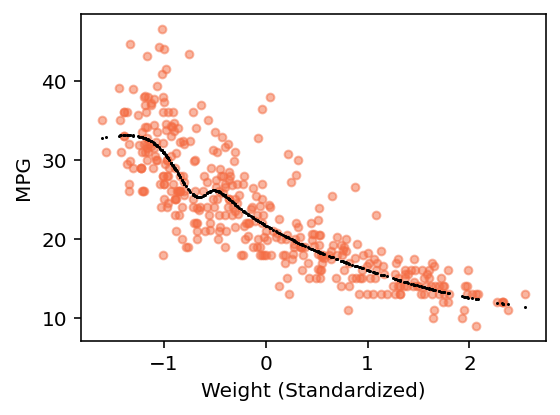

In [21]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.Tanh(),          # add nonlinearity
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1, nepochs=1500)

mshow(model, X=X, y=df_cars.MPG)